# Social Media Analytics | Module 8 Assignment | Paras Ahuja

In [1]:
import pandas as pd
import numpy as np
import math
import re
import nltk
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

### Preprocessing

In [2]:
df = pd.read_excel("SocialMediaInsightsforMachineLearning.xlsm")
df.to_csv("SMIFORML.csv", index=False, encoding="utf-8")
df = pd.read_csv("SMIFORML.csv")
df.head()

,Post Message,Type,Posted,Impressions,Weather,Weekend
0,"Dont forget, our Spring Savings Event is going...",Photo,2016-03-03 03:13:12,1220.0,Snow,N
1,https://www.facebook.com/natalie.birner/posts/...,SharedVideo,2016-03-03 06:05:04,165.0,Snow,N
2,Got a new bike in the last year or so and look...,Photo,2016-03-04 12:25:06,1398.0,Snow,Y
3,Just in! New HiVis Endura jerseys and riding s...,Photo,2016-03-04 13:16:22,1174.0,Snow,Y
4,Sale ends March 31,Photo,2016-03-04 14:19:07,1030.0,Snow,Y


Let's find our some information about the data and the features we have here.

In [3]:
df.shape

(102, 6)

Our data has 102 instances and 6 features.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102 entries, 0 to 101
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Post Message  101 non-null    object 
 1   Type          101 non-null    object 
 2   Posted        101 non-null    object 
 3   Impressions   101 non-null    float64
 4   Weather       44 non-null     object 
 5   Weekend       101 non-null    object 
dtypes: float64(1), object(5)
memory usage: 4.9+ KB


We notice that most of the features are non numerical except for Impressions. Let's check if there are any missing values in our dataset.

In [5]:
df.isnull().sum()

Post Message     1
Type             1
Posted           1
Impressions      1
Weather         58
Weekend          1
dtype: int64

We notice that there are 58 missing values in weather and 1 in each of the remaining features. Since we only have 102 instances, this means weather is missing more than 50% of the values are missing. We have no meaningful way of imputing this data. Consider the fact that we have information on when the post was made, however we do not have location data to find the weather, and it does not make sense to use most frequently occuring weather type for the rest of the posts. Therefore, we will drop this feature.

In [6]:
df.drop(columns="Weather", inplace=True)
df.head()

,Post Message,Type,Posted,Impressions,Weekend
0,"Dont forget, our Spring Savings Event is going...",Photo,2016-03-03 03:13:12,1220.0,N
1,https://www.facebook.com/natalie.birner/posts/...,SharedVideo,2016-03-03 06:05:04,165.0,N
2,Got a new bike in the last year or so and look...,Photo,2016-03-04 12:25:06,1398.0,Y
3,Just in! New HiVis Endura jerseys and riding s...,Photo,2016-03-04 13:16:22,1174.0,Y
4,Sale ends March 31,Photo,2016-03-04 14:19:07,1030.0,Y


Now that we have dropped one of the features, we need to impute the remaining missing features. Let's check what is missing.

In [7]:
df[df.isnull().any(axis=1)]

,Post Message,Type,Posted,Impressions,Weekend
101,NaN,NaN,NaN,NaN,NaN


So we notice that all the missing values are in the last row. We can simple drop the last row.

In [8]:
df.dropna(inplace=True)

Now we can analyze the data a bit before changing passing the data for processing by our ML algorithm.

### EDA

#### Post Message

Let's analyze this feature and see the most frequently appearing words.

In [9]:
pm = df["Post Message"].str.cat(sep=' ')
tokens = word_tokenize(pm)
vocabulary = set(tokens)
frequency_dist = nltk.FreqDist(tokens)

In [10]:
stop_words = set(stopwords.words('english'))
tokens = [w for w in tokens if not w in stop_words]

In [11]:
special_characters_removed = [re.sub('[^A-Za-z0-9]+', '', token) for token in tokens]
final = [w for w in special_characters_removed if len(w) != 0]

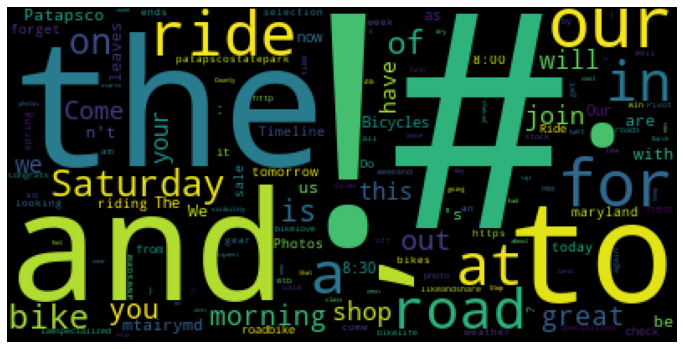

In [12]:
wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequency_dist)
fig=plt.figure(figsize=(12,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

We notice that we have symbols and stopwords appearing most frequently. We need to further process our data to see the actual words.

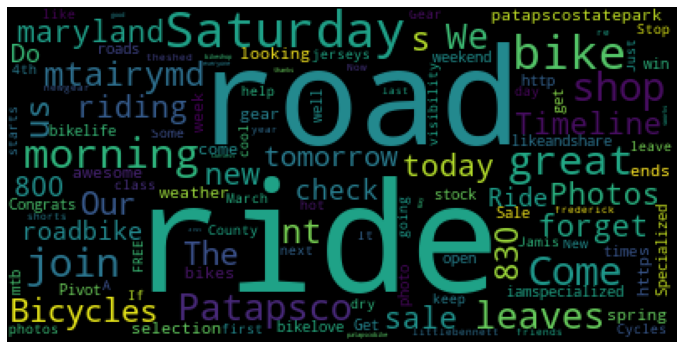

In [13]:
wordcloud = WordCloud()
frequency_dist = nltk.FreqDist(final)
wordcloud.generate_from_frequencies(frequency_dist)
fig=plt.figure(figsize=(12,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Here we notice that the word Saturday, road, ride, patapsco, etc. appear quite frequently. We can hypothesize that most of the posts were made on a weekend. But before we get to that, let's analyze our next feature.

#### Type

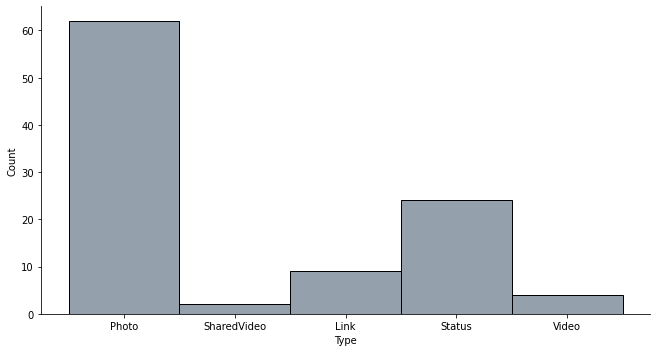

In [14]:
ax = sns.displot(df, x='Type', color="slategrey")
ax.fig.set_size_inches(10,5)

Indeed we notice that photos were shared most frequently than any other format. SharedVideo were the least shared.

In [15]:
df["Type"].describe()

count       101
unique        5
top       Photo
freq         62
Name: Type, dtype: object

Photos were shared 62 times.

#### Weekend

Earlier we hypothesized that most of the posts were made on a weekend. Let's check this.

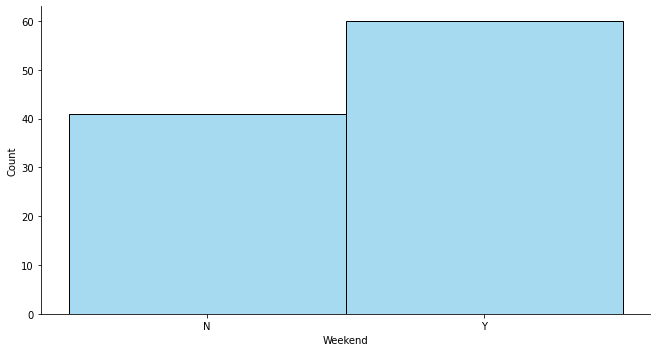

In [16]:
ax = sns.displot(df, x='Weekend', color="skyblue")
ax.fig.set_size_inches(10,5)

This is indeed correct. Most of the posts were made on a weekend, and it might be a Saturday when the posts were made.

In [17]:
df['Date'] = pd.to_datetime(df['Posted']) 
df['Day'] = df['Date'].dt.day_name() 
df.head()

,Post Message,Type,Posted,Impressions,Weekend,Date,Day
0,"Dont forget, our Spring Savings Event is going...",Photo,2016-03-03 03:13:12,1220.0,N,2016-03-03 03:13:12,Thursday
1,https://www.facebook.com/natalie.birner/posts/...,SharedVideo,2016-03-03 06:05:04,165.0,N,2016-03-03 06:05:04,Thursday
2,Got a new bike in the last year or so and look...,Photo,2016-03-04 12:25:06,1398.0,Y,2016-03-04 12:25:06,Friday
3,Just in! New HiVis Endura jerseys and riding s...,Photo,2016-03-04 13:16:22,1174.0,Y,2016-03-04 13:16:22,Friday
4,Sale ends March 31,Photo,2016-03-04 14:19:07,1030.0,Y,2016-03-04 14:19:07,Friday


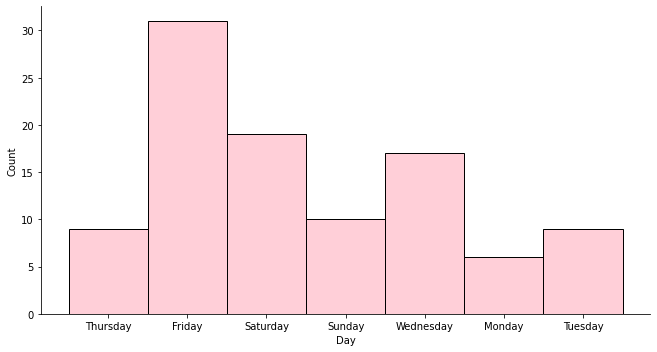

In [18]:
ax = sns.displot(df, x='Day', color="pink")
ax.fig.set_size_inches(10,5)

We notice that most of the posts were actually made on a Friday, followed by Saturday. For some reason Wednesday is the third most popular day of the week. Monday is the least popular - for obvious reasons. In order to fascilitate our analysis we will drop the Date, and Posted features, and keep the Day feature.

#### Model

In [19]:
df['Type'] = df['Type'].replace({'SharedVideo':0, 'Status':1, 'Video':2, 'Link':3, 'Photo':4})
df['Day'] = df['Day'].replace({'Monday': 0, 'Tuesday':1, 'Wednesday':2, 'Thursday':3, 'Friday':4, 'Saturday':5, 'Sunday':6})
df['Weekend'] = df['Weekend'].replace({'Y':1, 'N':0})

Before proceeding forward we will also drop a few feature.

In [20]:
df.drop(columns=["Posted", "Date"], inplace=True)
df.head()

,Post Message,Type,Impressions,Weekend,Day
0,"Dont forget, our Spring Savings Event is going...",4,1220.0,0,3
1,https://www.facebook.com/natalie.birner/posts/...,0,165.0,0,3
2,Got a new bike in the last year or so and look...,4,1398.0,1,4
3,Just in! New HiVis Endura jerseys and riding s...,4,1174.0,1,4
4,Sale ends March 31,4,1030.0,1,4


In [21]:
impressions = df.Impressions
df.drop(columns="Impressions", inplace=True)
df.insert(4, "Impressions", impressions)
df.head()

,Post Message,Type,Weekend,Day,Impressions
0,"Dont forget, our Spring Savings Event is going...",4,0,3,1220.0
1,https://www.facebook.com/natalie.birner/posts/...,0,0,3,165.0
2,Got a new bike in the last year or so and look...,4,1,4,1398.0
3,Just in! New HiVis Endura jerseys and riding s...,4,1,4,1174.0
4,Sale ends March 31,4,1,4,1030.0


Post Message seem important. Instead of dropping these, we will vectorize them, and keep the vectorized information and drop Post Message feature.

In [22]:
vectorizer = TfidfVectorizer()
sparse_out = vectorizer.fit_transform(df['Post Message'])
tfidf_df = pd.DataFrame(data = sparse_out.toarray(),
                        columns = vectorizer.get_feature_names())
frames = [df, tfidf_df]
df = pd.concat(frames, axis=1)

In [23]:
df.drop(columns="Post Message", inplace=True)
df.head()

,Type,Weekend,Day,Impressions,00,10153454399657045,10208748562539675,11th,1200,12pm,...,woods,works,would,www,year,years,you,your,yourself,youtu
0,4,0,3,1220.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
1,0,0,3,165.0,0.0,0.0,0.389042,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.302379,0.000000,0.0,0.0,0.0,0.0,0.0
2,4,1,4,1398.0,0.0,0.0,0.000000,0.0,0.214192,0.0,...,0.0,0.0,0.0,0.000000,0.196583,0.0,0.0,0.0,0.0,0.0
3,4,1,4,1174.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
4,4,1,4,1030.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


Next we need to binarize the Impressions feature for easier classification. 

***

*Note: I tried to build a regression model, however $R^2$ was negative, and MSE was large for multiple regression algorithms - I tried 5. Therefore, converted the impressions to binary label to better fit the data.*

***

In [24]:
y_mean = np.mean(df["Impressions"].values)
y_std = np.std(df['Impressions'].values)
target = pd.cut(df['Impressions'], bins = [np.NINF, (y_mean+0.5*y_std), np.Infinity], labels=["Low", "High"])
df['target'] = target
df.drop(columns="Impressions", inplace=True)
df.head()

,Type,Weekend,Day,00,10153454399657045,10208748562539675,11th,1200,12pm,147827197044,...,works,would,www,year,years,you,your,yourself,youtu,target
0,4,0,3,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,High
1,0,0,3,0.0,0.0,0.389042,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.302379,0.000000,0.0,0.0,0.0,0.0,0.0,Low
2,4,1,4,0.0,0.0,0.000000,0.0,0.214192,0.0,0.0,...,0.0,0.0,0.000000,0.196583,0.0,0.0,0.0,0.0,0.0,High
3,4,1,4,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,High
4,4,1,4,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,High


In [25]:
df['target'] = df['target'].replace({'Low': 0, 'High': 1})
df.head()

,Type,Weekend,Day,00,10153454399657045,10208748562539675,11th,1200,12pm,147827197044,...,works,would,www,year,years,you,your,yourself,youtu,target
0,4,0,3,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1
1,0,0,3,0.0,0.0,0.389042,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.302379,0.000000,0.0,0.0,0.0,0.0,0.0,0
2,4,1,4,0.0,0.0,0.000000,0.0,0.214192,0.0,0.0,...,0.0,0.0,0.000000,0.196583,0.0,0.0,0.0,0.0,0.0,1
3,4,1,4,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1
4,4,1,4,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1


In [26]:
X_features = [feature for feature in df.columns if feature != "target"]
X = df[X_features]
y = df["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [27]:
clf = RandomForestClassifier(n_estimators=100, random_state=100, criterion = "entropy")
clf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', random_state=100)

In [28]:
clf.score(X_test, y_test)

0.9047619047619048

We notice that our model predicts with ~90% accuracy. We did not have a lot of examples to work with. Furthermore, it may even depend on the way text is handled here. We vectorized the text, however other models may handle it differently and provide even higher level of accuracy. Perhaps the model could be made better with more data in this instance because we cannot guarantee generalization of this model.